In [1]:
from matplotlib.lines import lineStyles

"""
title: The headline or short title of the article.
text: The main body of the news article, written in medium-length text (~200-300 words).
date: The publication date of the article.
source: The media organization that published the article (may contain missing values).
author: The name of the author who wrote the article (may contain missing values).
category: The category to which the article belongs (Politics, Technology, Health, Sports, etc.).
label: The target classification, either real or fake.
"""

'\ntitle: The headline or short title of the article.\ntext: The main body of the news article, written in medium-length text (~200-300 words).\ndate: The publication date of the article.\nsource: The media organization that published the article (may contain missing values).\nauthor: The name of the author who wrote the article (may contain missing values).\ncategory: The category to which the article belongs (Politics, Technology, Health, Sports, etc.).\nlabel: The target classification, either real or fake.\n'

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

matplotlib.use("Agg")
plt.switch_backend("Agg")

%matplotlib inline

In [19]:
# for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# set a nice seaborn style
sns.set(style="whitegrid")

In [20]:
df = pd.read_csv("./fake_news_dataset.csv")
df.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [21]:
# convert the date col to datetime -> it was originally string
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [22]:
missing_values = df.isnull().sum()
print(f"missing values: {missing_values} - total values: {df.shape[0]}")

missing values: title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64 - total values: 20000


In [23]:
df.dropna(subset=['text', 'label'], inplace=True)
df.shape[0]

20000

In [24]:
df['title_length'] = df['title'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['text_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         20000 non-null  object        
 1   text          20000 non-null  object        
 2   date          20000 non-null  datetime64[ns]
 3   source        19000 non-null  object        
 4   author        19000 non-null  object        
 5   category      20000 non-null  object        
 6   label         20000 non-null  object        
 7   title_length  20000 non-null  int64         
 8   text_length   20000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 1.4+ MB


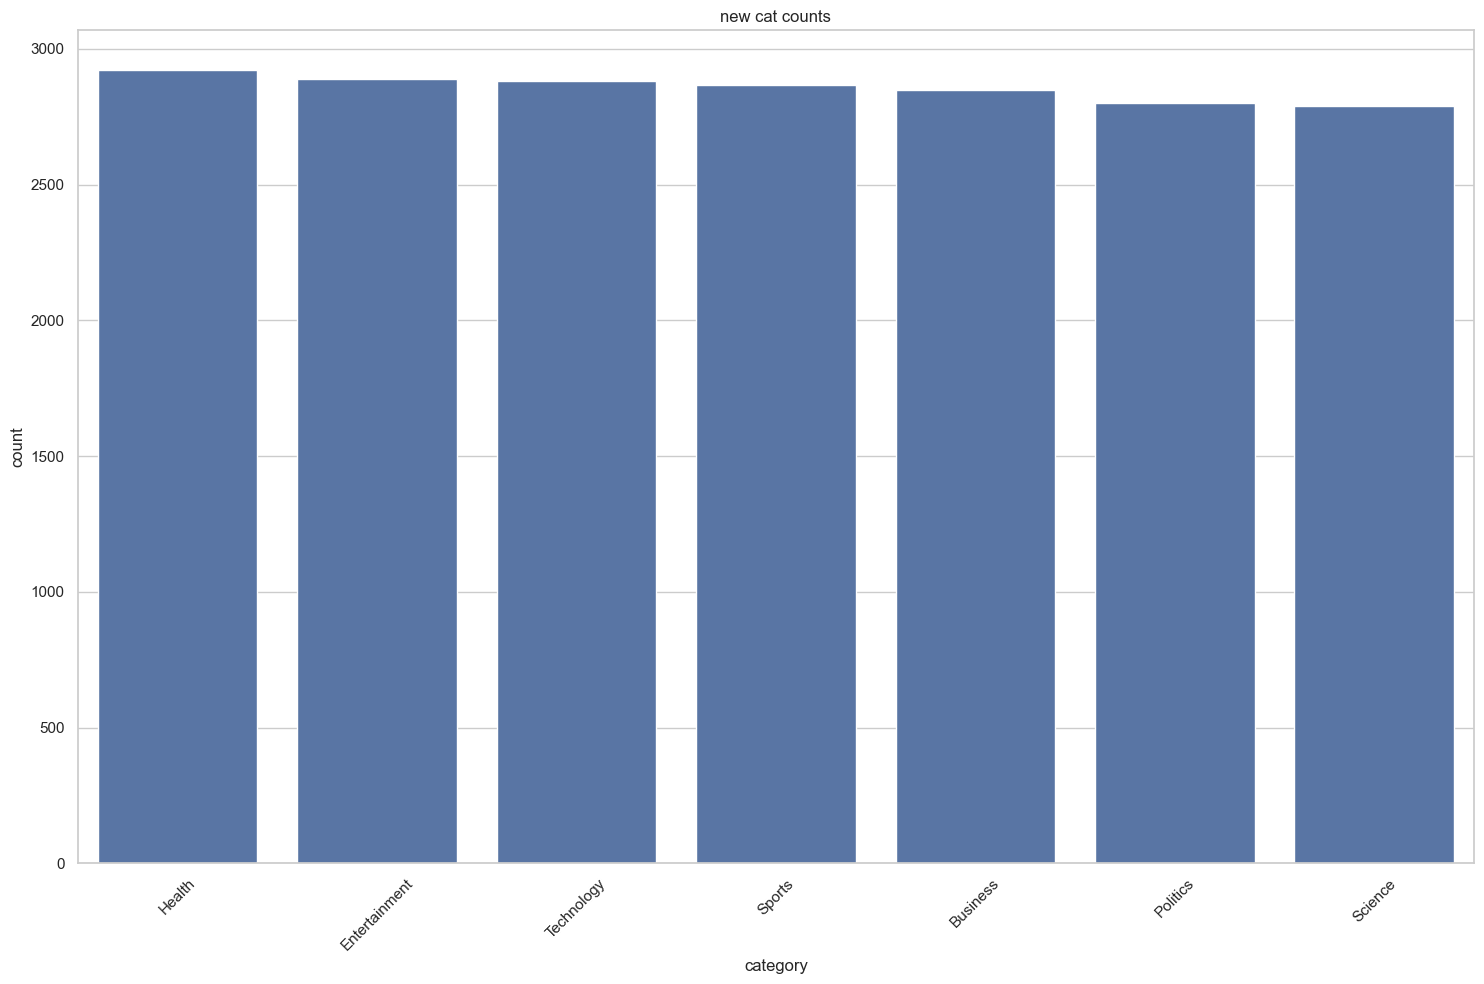

In [25]:
# exploratory data analysis
plt.figure(figsize=(15, 10))

# category distribution
# using a countplot -> pie charts can be limited for many categories
sns.countplot(x='category', data=df, order=df['category'].value_counts().index)
plt.title('new cat counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

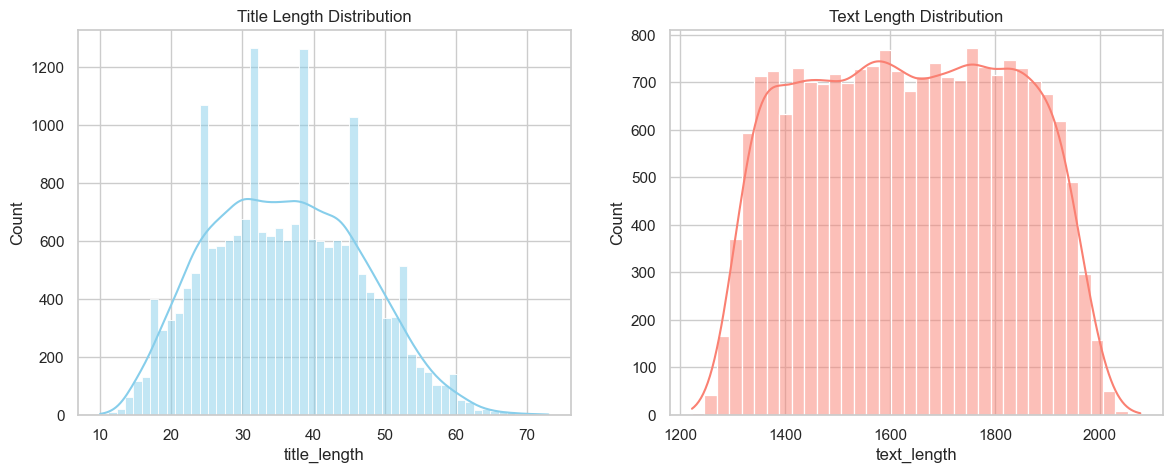

In [26]:
# numerical features analysis
# histograms for title and text length
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(
    df['title_length'],
    kde=True,
    ax=axes[0],
    color='skyblue'
)
axes[0].set_title('Title Length Distribution')

sns.histplot(
    df['text_length'],
    kde=True,
    ax=axes[1],
    color='salmon'
)
axes[1].set_title('Text Length Distribution')
plt.show()

not enough numeric columns to plot correlation heatmap


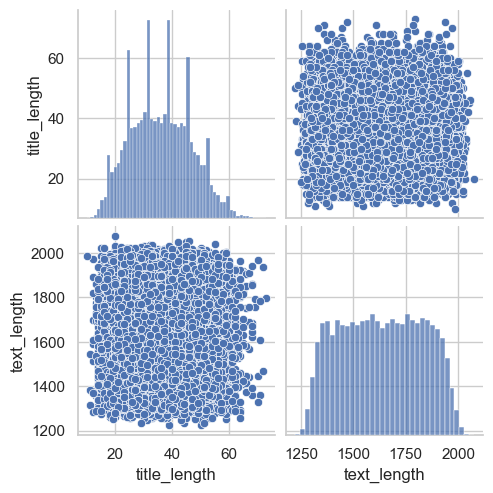

In [27]:
# correlation analysis
# we select only numeric columns for correlation analysis
# in this case we have 'title_length' & 'text_length'
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("not enough numeric columns to plot correlation heatmap")

# a pair plot can help visualize their relationship
sns.pairplot(numeric_df)
plt.show()

In [28]:
# for prediction model, we use TF-IDF to covert the 'text' cols into numeric features
# then we use logistic regression to predict 'label'.
# this is a minimal predictor to demonstrate the approach

from sklearn.preprocessing import LabelEncoder

# encode the target var: assuming labels are string like 'fake' and 'true'
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'].str.lower())

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform(df['text'])
X = X_text
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# calculate and display the prediction accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5098


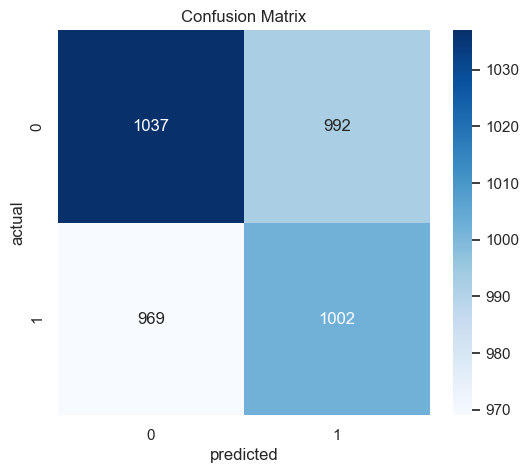

In [29]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

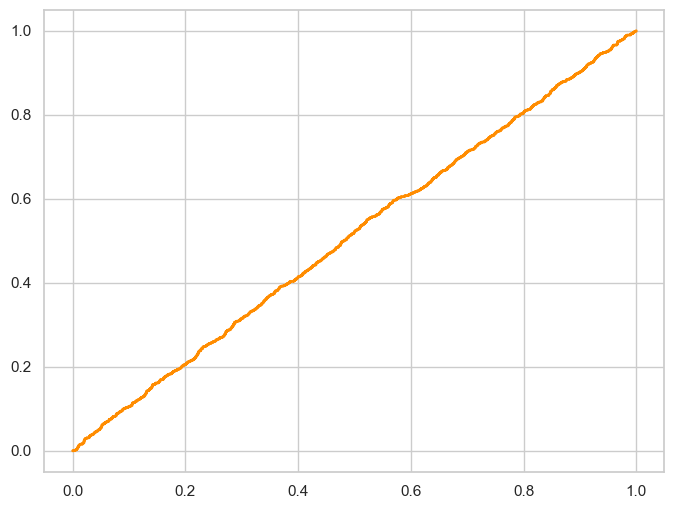

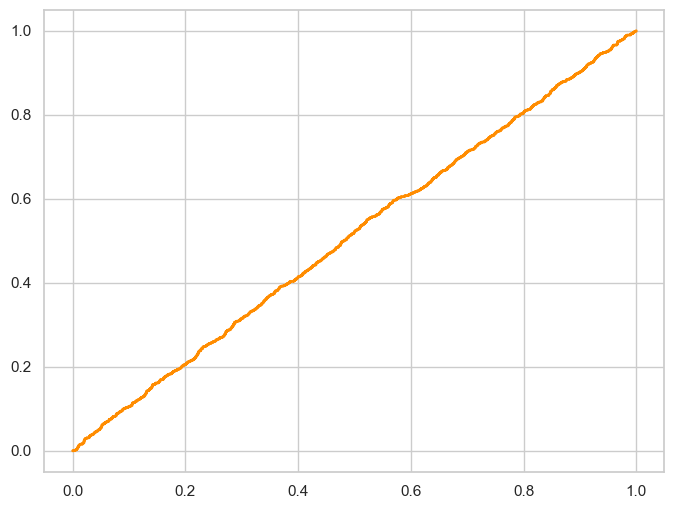

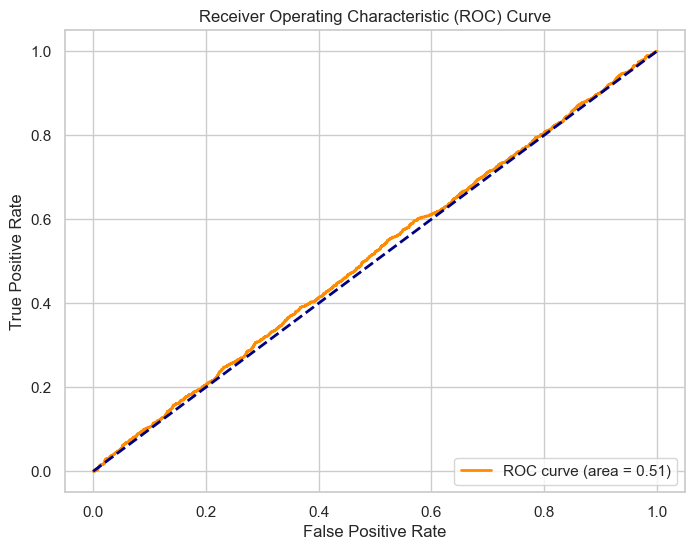

In [36]:
# roc curve
# since we have a binary classification, compute the ROC curve
y_probs = model.predict_proba(X_test)[:, 1] # todo
fpr, tpr, threshold = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()